

```
# This is formatted as code
```

#Setup and Imports
We install and import required libraries:

- **pandas, numpy**: data handling  
- **matplotlib, seaborn, plotly**: visualization  
- **sklearn**: clustering & predictive models  
- **mlxtend**: market basket analysis  
- **prophet**: forecasting

In [4]:
# Importing basic libraries

import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Importing modeling libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from mlxtend.frequent_patterns import apriori, association_rules
from prophet import Prophet

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

#Load and Inspect data
### 📂 Load & Inspect Data
We load the dataset and inspect its structure:
- Data types  
- Preview of sample rows

In [5]:
#Reading the dataset
df=pd.read_csv('/content/Project Work.csv')

/tmp/ipython-input-337605821.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/Project Work.csv')


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541906 non-null  object 
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541905 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), object(6)
memory usage: 33.1+ MB


In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,6,12-01-2010 08:26,2.55,17850.0,united kingdom
1,536365,71053,White Metal Lantern,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM cupid hearts coat hanger,8,12-01-2010 08:26,2.75,17850.0,UNITED KINGDOM
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


#Data Cleaning
### 🧹 Data Cleaning
Steps:
1. Investigate missing values primarily in CustomerID column and Remove duplicates  
2. Fix data types (InvoiceNo → string, Quantity/UnitPrice → numeric, CustomerID → int)
3. Parse InvoiceDate to datetime and create additional coolumns including the 'day'
4. Create `TotalPrice = Quantity × UnitPrice`  
5. Flag cancelled invoices (InvoiceNo starting with 'C')


In [8]:
unique_invoices = df["InvoiceNo"].nunique()
print("Unique Invoice Numbers:", unique_invoices)

Unique Invoice Numbers: 25900


In [9]:
df["InvoiceNo"].unique()[:10]  # show first 10 unique invoice numbers


array(['536365', '536366', '536367', '536368', '536369', '536370',
       '536371', '536372', '536373', '536374'], dtype=object)

In [10]:
# If at least one valid CustomerID exists in an invoice, fill all NaNs with it
df['CustomerID'] = df.groupby('InvoiceNo')['CustomerID'].transform(lambda x: x.fillna(x.mode()[0]) if x.notna().any() else x)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541906 non-null  object 
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541905 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), object(6)
memory usage: 33.1+ MB


In [12]:
# Unique invoice numbers where CustomerID is missing
missing_invoices = df.loc[df['CustomerID'].isna(), 'InvoiceNo'].unique()

print("Number of invoices with missing CustomerID:", len(missing_invoices))
print("First 10 examples:", missing_invoices[:10])


Number of invoices with missing CustomerID: 3710
First 10 examples: ['536414' '536544' '536545' '536546' '536547' '536549' '536550' '536552'
 '536553' '536554']


In [13]:
# Count missing rows per invoice
missing_invoice_counts = (
    df[df['CustomerID'].isna()]                # filter missing
    .groupby('InvoiceNo')                      # group by invoice
    .size()                                    # count rows
    .reset_index(name='MissingRows')           # convert to dataframe
    .sort_values(by='MissingRows', ascending=False)  # sort descending
)

print(missing_invoice_counts.head(25))  # show top 25


     InvoiceNo  MissingRows
3052    573585         1114
3511    581219          749
3522    581492          731
3478    580729          721
1977    558475          705
3429    579777          687
3510    581217          676
83      537434          675
3479    580730          662
143     538071          652
3446    580367          650
3436    580115          645
3521    581439          635
3486    580983          629
3346    578344          622
183     538349          620
3347    578347          606
102     537638          601
69      537237          597
27      536876          593
3238    576617          593
14      536592          592
114     537823          591
3262    576837          585
3403    579508          578


In [14]:
# Copy original dataset
df1 = df.copy()

# Fill missing CustomerID based on other rows in the same invoice
df1['CustomerID'] = df1.groupby('InvoiceNo')['CustomerID'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# Check how many still missing
print("Missing after invoice-based imputation:", df1['CustomerID'].isna().sum())

#Not Working as mising values still remains

/tmp/ipython-input-1856912046.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df1['CustomerID'] = df1.groupby('InvoiceNo')['CustomerID'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


Missing after invoice-based imputation: 135080


In [15]:

#Creating another dataframne by labelling missing CustomerID as Anonymous for studying them separately (basket size, products etc)
df2 = df.copy()

# Label missing IDs as "Anonymous"
df2['CustomerID'] = df2['CustomerID'].astype('string').fillna("Anonymous")

# Quick check: how many anonymous invoices?
anon_invoices = df2[df2['CustomerID']=="Anonymous"]['InvoiceNo'].nunique()
print("Anonymous invoices:", anon_invoices)


Anonymous invoices: 3710


In [16]:
#Examining and Dropping Duplicates
# Get all duplicate rows (keep=False marks all copies as duplicates)
duplicates = df[df.duplicated(keep=False)]

print("Number of duplicate rows:", len(duplicates))
duplicates.head(10)   # preview first 10


Number of duplicate rows: 10147


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12-01-2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12-01-2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12-01-2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12-01-2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12-01-2010 11:45,2.95,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12-01-2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12-01-2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12-01-2010 11:45,4.95,17908.0,United Kingdom
548,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12-01-2010 11:49,2.95,17920.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12-01-2010 11:49,2.95,17920.0,United Kingdom


In [17]:
 #Examining the duplicates side by side
duplicates_sorted = duplicates.sort_values(list(df.columns))
print("Number of duplicate rows:", len(duplicates_sorted))
duplicates_sorted.head(20)   # preview first 20


Number of duplicate rows: 10147


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12-01-2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12-01-2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12-01-2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12-01-2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12-01-2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12-01-2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12-01-2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12-01-2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12-01-2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12-01-2010 11:49,1.65,17920.0,United Kingdom


In [18]:
#Dropping the duplicates
df.drop_duplicates(inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536638 non-null  object 
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536637 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), object(6)
memory usage: 36.8+ MB


In [20]:
#Dealing with InvoiceDate column inconsistencies (Mixed format)
from dateutil import parser
import pandas as pd

# Safe parsing function
def parse_invoice_date(x):
    try:
        return parser.parse(x)
    except:
        return pd.NaT

# Apply to column
df['InvoiceDate_parsed'] = df['InvoiceDate'].apply(parse_invoice_date)

# Check how many failed
print("Unparsed rows:", df['InvoiceDate_parsed'].isna().sum())

Unparsed rows: 0


In [21]:
   #Creating additional columns for time series analysis
   df['Invoice_Year'] = df['InvoiceDate_parsed'].dt.year
df['Invoice_Month'] = df['InvoiceDate_parsed'].dt.month
df['Invoice_Day'] = df['InvoiceDate_parsed'].dt.day
df['Invoice_Hour'] = df['InvoiceDate_parsed'].dt.hour
df['Invoice_Minute'] = df['InvoiceDate_parsed'].dt.minute
df['Invoice_DOW'] = df['InvoiceDate_parsed'].dt.day_name()


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           536641 non-null  object        
 1   StockCode           536641 non-null  object        
 2   Description         535187 non-null  object        
 3   Quantity            536638 non-null  object        
 4   InvoiceDate         536641 non-null  object        
 5   UnitPrice           536637 non-null  float64       
 6   CustomerID          401604 non-null  float64       
 7   Country             536641 non-null  object        
 8   InvoiceDate_parsed  536641 non-null  datetime64[ns]
 9   Invoice_Year        536641 non-null  int32         
 10  Invoice_Month       536641 non-null  int32         
 11  Invoice_Day         536641 non-null  int32         
 12  Invoice_Hour        536641 non-null  int32         
 13  Invoice_Minute      536641 non-nul

In [23]:
# ---- Data Type Conversions ----

# 1. Convert Quantity → integer (nullable, to allow NaNs if any bad rows exist)
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').astype('Int32')

# 2. CustomerID → nullable integer (removes .0 from floats)
df['CustomerID'] = df['CustomerID'].astype('Int64')

# 3. Convert categorical fields
df['Country'] = df['Country'].astype('category')
df['Invoice_DOW'] = df['Invoice_DOW'].astype('category')

# 4. Convert IDs to string (avoid numeric issues)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)
df['Description'] = df['Description'].astype(str)

# 5. Optimize UnitPrice to float32 (saves memory)
#float64 = double precision floating point (8 bytes per value).
#dataset has ~540k rows → 541,905 × 8 bytes ≈ 4.3 MB just for this one column.
#float32 = single precision floating point (4 bytes per value).
#Same data, but half the memory → ~2.1 MB.

df['UnitPrice'] = df['UnitPrice'].astype('float32')

print(df.dtypes)
print(df.info(memory_usage='deep'))

InvoiceNo                     object
StockCode                     object
Description                   object
Quantity                       Int32
InvoiceDate                   object
UnitPrice                    float32
CustomerID                     Int64
Country                     category
InvoiceDate_parsed    datetime64[ns]
Invoice_Year                   int32
Invoice_Month                  int32
Invoice_Day                    int32
Invoice_Hour                   int32
Invoice_Minute                 int32
Invoice_DOW                 category
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           536641 non-null  object        
 1   StockCode           536641 non-null  object        
 2   Description         536641 non-null  object        
 3   Quantity            536636 non-null

In [24]:
#InvoiceNo, StockCode and description are identified as  object. Since these are IDs/text,  should convert them to string/category
#InvoiceNo → string (too many unique values, categorical would waste memory).
#StockCode → category (tens of thousands of repeats, efficient).
# Convert identifiers to string
df['InvoiceNo'] = df['InvoiceNo'].astype('string')
df['StockCode'] = df['StockCode'].astype('category')
df['Description'] = df['Description'].astype('string')
print(df.dtypes)
print(df.info(memory_usage='deep'))

InvoiceNo             string[python]
StockCode                   category
Description           string[python]
Quantity                       Int32
InvoiceDate                   object
UnitPrice                    float32
CustomerID                     Int64
Country                     category
InvoiceDate_parsed    datetime64[ns]
Invoice_Year                   int32
Invoice_Month                  int32
Invoice_Day                    int32
Invoice_Hour                   int32
Invoice_Minute                 int32
Invoice_DOW                 category
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           536641 non-null  string        
 1   StockCode           536641 non-null  category      
 2   Description         536641 non-null  string        
 3   Quantity            536636 non-null

In [25]:
#We have 5 missing values in Quanitity and 4 missing values in UnitPrice. Considering that it constitutes a very small fraction of the dataset, removing rows with these missing values
df.dropna(subset=['Quantity', 'UnitPrice'], inplace=True)



In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536632 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           536632 non-null  string        
 1   StockCode           536632 non-null  category      
 2   Description         536632 non-null  string        
 3   Quantity            536632 non-null  Int32         
 4   InvoiceDate         536632 non-null  object        
 5   UnitPrice           536632 non-null  float32       
 6   CustomerID          401595 non-null  Int64         
 7   Country             536632 non-null  category      
 8   InvoiceDate_parsed  536632 non-null  datetime64[ns]
 9   Invoice_Year        536632 non-null  int32         
 10  Invoice_Month       536632 non-null  int32         
 11  Invoice_Day         536632 non-null  int32         
 12  Invoice_Hour        536632 non-null  int32         
 13  Invoice_Minute      536632 non-nul

In [27]:
# Check the number of missing values per column
print(df.isnull().sum())


InvoiceNo                  0
StockCode                  0
Description                0
Quantity                   0
InvoiceDate                0
UnitPrice                  0
CustomerID            135037
Country                    0
InvoiceDate_parsed         0
Invoice_Year               0
Invoice_Month              0
Invoice_Day                0
Invoice_Hour               0
Invoice_Minute             0
Invoice_DOW                0
dtype: int64


In [28]:
# Creating a Derived column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Flagging cancellations through a Boolean Column
df['IsCancelled'] = df['InvoiceNo'].str.startswith('C')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536632 entries, 0 to 541908
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           536632 non-null  string        
 1   StockCode           536632 non-null  category      
 2   Description         536632 non-null  string        
 3   Quantity            536632 non-null  Int32         
 4   InvoiceDate         536632 non-null  object        
 5   UnitPrice           536632 non-null  float32       
 6   CustomerID          401595 non-null  Int64         
 7   Country             536632 non-null  category      
 8   InvoiceDate_parsed  536632 non-null  datetime64[ns]
 9   Invoice_Year        536632 non-null  int32         
 10  Invoice_Month       536632 non-null  int32         
 11  Invoice_Day         536632 non-null  int32         
 12  Invoice_Hour        536632 non-null  int32         
 13  Invoice_Minute      536632 non-nul

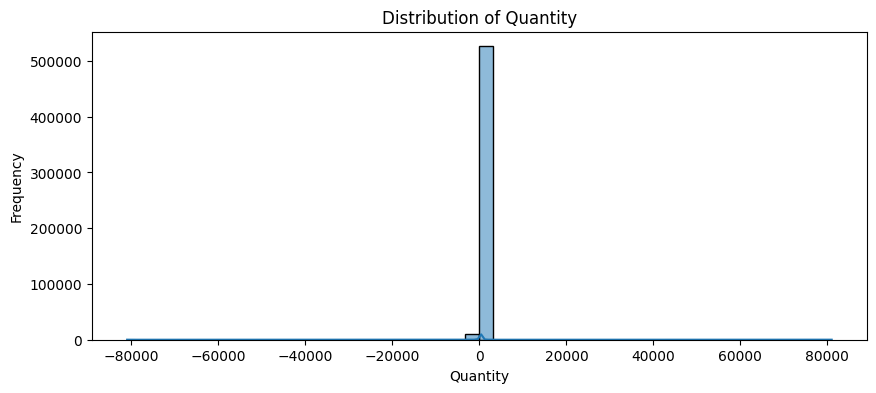

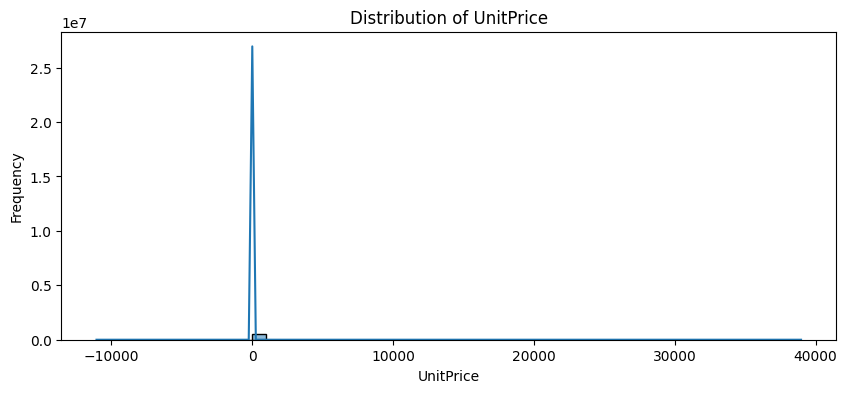

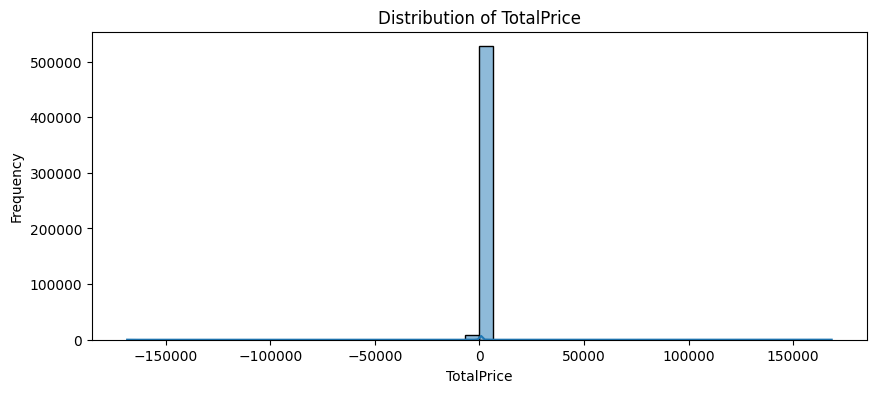

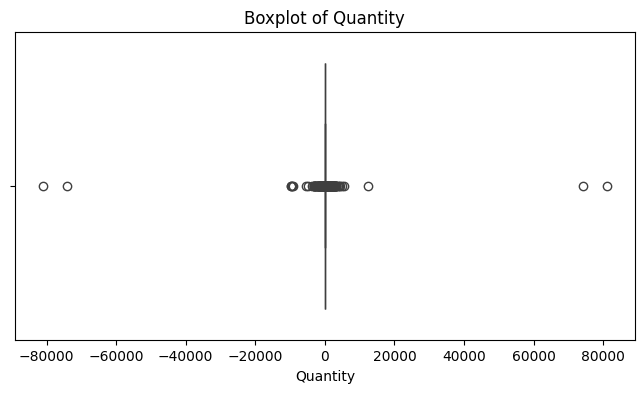

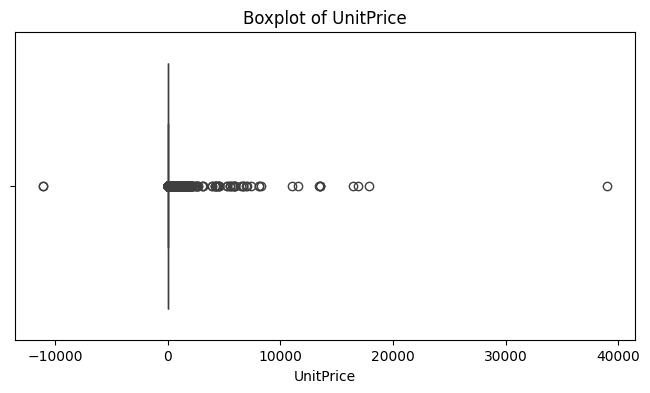

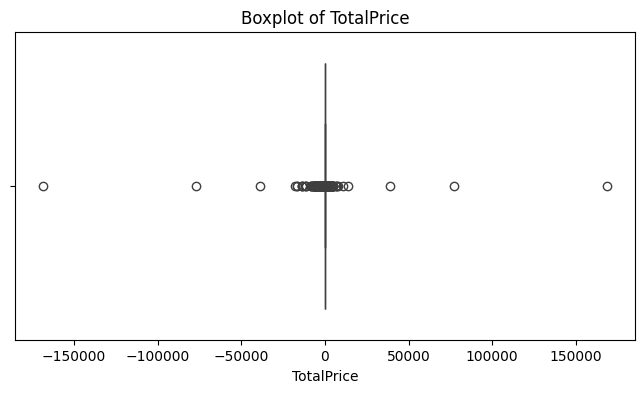

Number of negative values in Quantity: 10587
Number of negative values in UnitPrice: 2
Number of negative values in TotalPrice: 9253
Skewness of Quantity: -0.26
Skewness of UnitPrice: 185.60
Skewness of TotalPrice: -0.96
Top 10 products by revenue:
Description
DOTCOM POSTAGE                        206245.480286
REGENCY CAKESTAND 3 TIER              164459.487793
WHITE HANGING HEART T-LIGHT HOLDER     99597.119963
PARTY BUNTING                          98243.879319
JUMBO BAG RED RETROSPOT                92175.788571
RABBIT NIGHT LIGHT                     66661.628772
POSTAGE                                66230.639969
PAPER CHAIN KIT 50'S CHRISTMAS         63715.239599
ASSORTED COLOUR BIRD ORNAMENT          58792.421878
CHILLI LIGHTS                          53746.659208
Name: TotalPrice, dtype: Float64


/tmp/ipython-input-4130322638.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


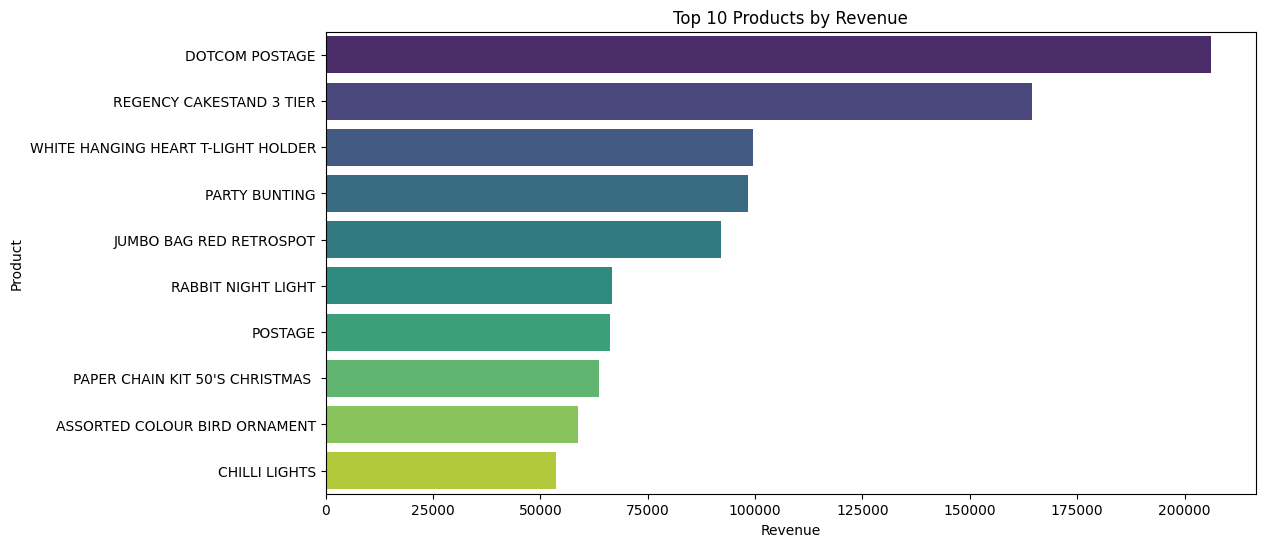

In [30]:
#Investigating the negative values in various data coulmns to see their relevance
# ------------------------------
# 1️⃣ Distribution of Quantity, UnitPrice, TotalPrice
# ------------------------------
numeric_cols = ['Quantity', 'UnitPrice', 'TotalPrice']

for col in numeric_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# ------------------------------
# 2️⃣ Boxplot to identify outliers
# ------------------------------
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# ------------------------------
# 3️⃣ Negative values
# ------------------------------
for col in numeric_cols:
    neg_count = (df[col] < 0).sum()
    print(f"Number of negative values in {col}: {neg_count}")

# ------------------------------
# 4️⃣ Skewness
# ------------------------------
for col in numeric_cols:
    skewness = df[col].skew()
    print(f"Skewness of {col}: {skewness:.2f}")

# ------------------------------
# 5️⃣ Top 10 products by revenue
# ------------------------------
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print("Top 10 products by revenue:")
print(top_products)

# Optional: Bar plot for top 10 products
plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.show()


In [31]:
    # Show rows where UnitPrice is negative
negative_prices = df[df['UnitPrice'] < 0]
print(negative_prices)

#These are two entries termed as Bad Debt. Need to separate these two entries from our analysis.

       InvoiceNo StockCode      Description  Quantity       InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  08-12-2011 14:51   
299984   A563187         B  Adjust bad debt         1  08-12-2011 14:52   

          UnitPrice  CustomerID         Country  InvoiceDate_parsed  \
299983 -11062.05957        <NA>  United Kingdom 2011-08-12 14:51:00   
299984 -11062.05957        <NA>  United Kingdom 2011-08-12 14:52:00   

        Invoice_Year  Invoice_Month  Invoice_Day  Invoice_Hour  \
299983          2011              8           12            14   
299984          2011              8           12            14   

        Invoice_Minute Invoice_DOW   TotalPrice  IsCancelled  
299983              51      Friday -11062.05957        False  
299984              52      Friday -11062.05957        False  


In [32]:
#Dropping two rows with negative UnitPrice
# Drop rows where UnitPrice is negative
df = df[df['UnitPrice'] >= 0]


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536630 entries, 0 to 541908
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           536630 non-null  string        
 1   StockCode           536630 non-null  category      
 2   Description         536630 non-null  string        
 3   Quantity            536630 non-null  Int32         
 4   InvoiceDate         536630 non-null  object        
 5   UnitPrice           536630 non-null  float32       
 6   CustomerID          401595 non-null  Int64         
 7   Country             536630 non-null  category      
 8   InvoiceDate_parsed  536630 non-null  datetime64[ns]
 9   Invoice_Year        536630 non-null  int32         
 10  Invoice_Month       536630 non-null  int32         
 11  Invoice_Day         536630 non-null  int32         
 12  Invoice_Hour        536630 non-null  int32         
 13  Invoice_Minute      536630 non-nul

Top 20 returned items (Cancelled orders):
Description
PAPER CRAFT , LITTLE BIRDIE            -80995
MEDIUM CERAMIC TOP STORAGE JAR         -74494
ROTATING SILVER ANGELS T-LIGHT HLDR     -9376
Manual                                  -4066
FAIRY CAKE FLANNEL ASSORTED COLOUR      -3150
WHITE HANGING HEART T-LIGHT HOLDER      -2578
GIN + TONIC DIET METAL SIGN             -2030
HERB MARKER BASIL                       -1527
FELTCRAFT DOLL MOLLY                    -1447
TEA TIME PARTY BUNTING                  -1424
PAPER POCKET TRAVELING FAN              -1385
PINK BLUE FELT CRAFT TRINKET BOX        -1321
WORLD WAR 2 GLIDERS ASSTD DESIGNS       -1200
Discount                                -1194
COLOUR GLASS. STAR T-LIGHT HOLDER       -1174
JUMBO BAG RED RETROSPOT                 -1115
HOME SWEET HOME MUG                     -1052
PANTRY CHOPPING BOARD                    -946
PLACE SETTING WHITE HEART                -890
FELTCRAFT BUTTERFLY HEARTS               -877
Name: Quantity, dtype: Int

/tmp/ipython-input-3856014122.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_cancelled.values, y=top20_cancelled.index, palette="Reds_r")


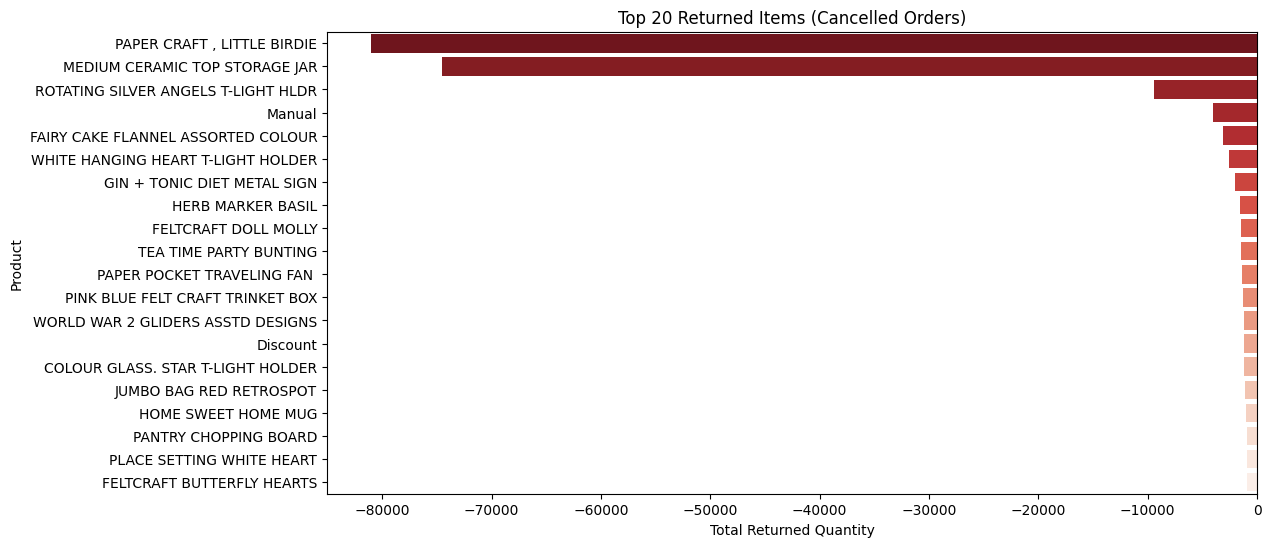


Top 20 items with negative quantities (NOT cancelled):
Description
nan                             -46156
printing smudges/thrown away    -19200
Unsaleable, destroyed.          -15644
check                           -13247
?                                -9496
Printing smudges/thrown away     -9058
Damaged                          -7540
throw away                       -5368
damages                          -4338
incorrect stock entry.           -4320
thrown away                      -4110
wrongly marked. 23343 in box     -3100
damages wax                      -2844
mouldy, thrown away.             -2600
thrown away-can't sell           -2472
sold as set on dotcom            -2393
Thrown away-rusty                -2376
?missing                         -2331
??                               -1849
damaged                          -1824
Name: Quantity, dtype: Int32

Total negative revenue (non-cancelled cases): 0.00


/tmp/ipython-input-3856014122.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_non_cancelled.values, y=top20_non_cancelled.index, palette="Blues_r")


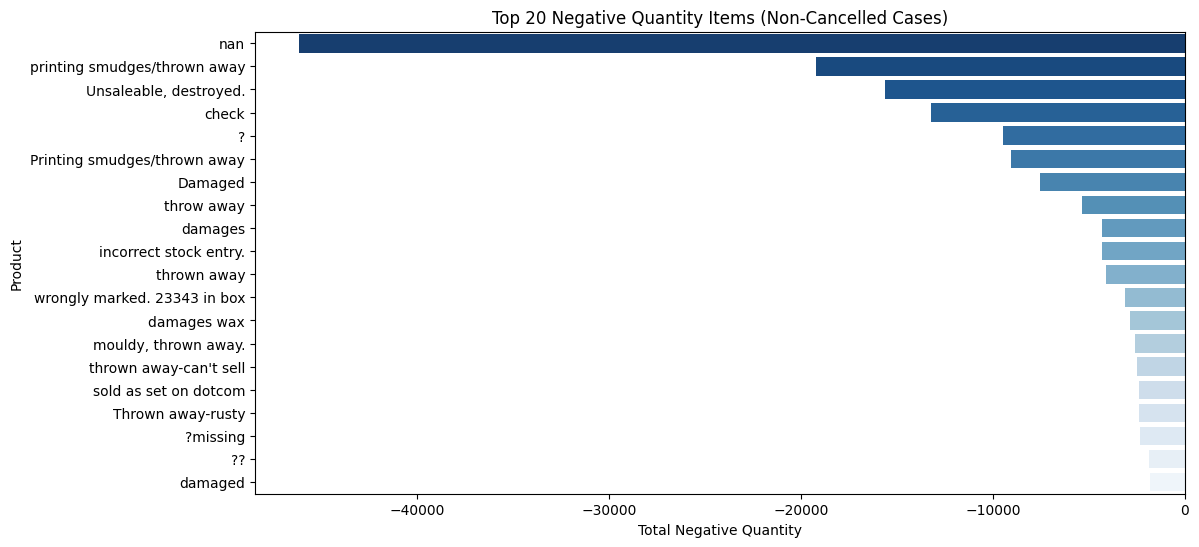

In [34]:
# 1️⃣ Cancelled orders with negative Quantity
cancelled_returns = df[(df['Quantity'] < 0) & (df['IsCancelled'] == True)]

top20_cancelled = (
    cancelled_returns.groupby('Description')['Quantity']
    .sum()
    .sort_values()
    .head(20)   # Most returned items (largest negatives)
)

print("Top 20 returned items (Cancelled orders):")
print(top20_cancelled)

# Optional plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(x=top20_cancelled.values, y=top20_cancelled.index, palette="Reds_r")
plt.title("Top 20 Returned Items (Cancelled Orders)")
plt.xlabel("Total Returned Quantity")
plt.ylabel("Product")
plt.show()


# 2️⃣ Negative quantities where NOT cancelled (discard/wastage/mismatch)
non_cancelled_neg = df[(df['Quantity'] < 0) & (df['IsCancelled'] == False)]

top20_non_cancelled = (
    non_cancelled_neg.groupby('Description')['Quantity']
    .sum()
    .sort_values()
    .head(20)
)

print("\nTop 20 items with negative quantities (NOT cancelled):")
print(top20_non_cancelled)

# Total negative revenue for these cases
total_negative_revenue = non_cancelled_neg['TotalPrice'].sum()
print(f"\nTotal negative revenue (non-cancelled cases): {total_negative_revenue:,.2f}")

# Optional plot
plt.figure(figsize=(12,6))
sns.barplot(x=top20_non_cancelled.values, y=top20_non_cancelled.index, palette="Blues_r")
plt.title("Top 20 Negative Quantity Items (Non-Cancelled Cases)")
plt.xlabel("Total Negative Quantity")
plt.ylabel("Product")
plt.show()


In [35]:
#Want to analyse top few reasons for non cancelled items with negative quantity count.

from collections import Counter
import re

# Collect all words
words = (
    non_cancelled_neg['Description']
    .dropna()
    .str.lower()
    .str.replace(r'[^a-z\s]', '', regex=True)   # remove punctuation/numbers
    .str.split()
)

word_list = [word for sublist in words for word in sublist]

# Get top 30 most common words
top_words = Counter(word_list).most_common(30)
print(top_words)



[('nan', 862), ('check', 125), ('damaged', 65), ('damages', 55), ('sold', 36), ('dotcom', 34), ('as', 30), ('set', 25), ('on', 23), ('away', 21), ('thrown', 15), ('wet', 14), ('missing', 11), ('unsaleable', 10), ('wrongly', 9), ('stock', 9), ('destroyed', 9), ('adjustment', 7), ('sets', 6), ('lost', 6), ('in', 6), ('up', 5), ('wrong', 5), ('crushed', 5), ('ebay', 5), ('rusty', 5), ('barcode', 4), ('smashed', 4), ('sales', 3), ('reverse', 3)]


In [36]:
# Extracting a dataset without these non cancelled negative quantity rows


df_clean = df.drop(non_cancelled_neg.index)


In [37]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 535294 entries, 0 to 541908
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           535294 non-null  string        
 1   StockCode           535294 non-null  category      
 2   Description         535294 non-null  string        
 3   Quantity            535294 non-null  Int32         
 4   InvoiceDate         535294 non-null  object        
 5   UnitPrice           535294 non-null  float32       
 6   CustomerID          401595 non-null  Int64         
 7   Country             535294 non-null  category      
 8   InvoiceDate_parsed  535294 non-null  datetime64[ns]
 9   Invoice_Year        535294 non-null  int32         
 10  Invoice_Month       535294 non-null  int32         
 11  Invoice_Day         535294 non-null  int32         
 12  Invoice_Hour        535294 non-null  int32         
 13  Invoice_Minute      535294 non-nul

#Data Analysis

In [38]:
#Additional packages for use
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import IsolationForest

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Prophet: use try/except so notebook won't crash if not installed
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

from scipy import stats
from scipy.stats import f_oneway, chi2_contingency

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,4)

# Small helpers
def quick_info(df, n=5):
    print("Shape:", df.shape)
    display(df.head(n))
    display(df.describe(include='all').T)

def save_csv(df, name):
    path = f"{name}.csv"
    df.to_csv(path, index=False)
    print("Saved:", path)

print("Setup done. Prophet available:", PROPHET_AVAILABLE)

Setup done. Prophet available: True


In [39]:
#Data Anmolies/Missing Structure, Quick Check into Basic Data frame
# Missing fraction per column
missing_frac = df_clean.isna().mean().sort_values(ascending=False)
print("Missing fraction per column:")
print(missing_frac[missing_frac>0].round(4))

# Check types of critical columns
print("\nUnique counts (invoices/customers/products):")
print("Unique invoices:", df_clean['InvoiceNo'].nunique())
print("Unique customers (non-null):", df_clean['CustomerID'].nunique())
print("Unique products (StockCode):", df_clean['StockCode'].nunique())

# Quick checks for returns/cancellations and negative UnitPrice
print("\nReturn rows (Quantity < 0):", (df_clean['Quantity'] < 0).sum())
print("Cancelled invoices (IsCancelled True):", df_clean['IsCancelled'].sum())
print("Zero or negative UnitPrice rows:", (df_clean['UnitPrice'] <= 0).sum())


Missing fraction per column:
CustomerID    0.2498
dtype: float64

Unique counts (invoices/customers/products):
Unique invoices: 24562
Unique customers (non-null): 4372
Unique products (StockCode): 3957

Return rows (Quantity < 0): 9251
Cancelled invoices (IsCancelled True): 9251
Zero or negative UnitPrice rows: 1174


#Univariate analysis — numeric columns (Quantity, UnitPrice, TotalPrice)

##Distributions, skew, and outliers to understand typical transaction sizes

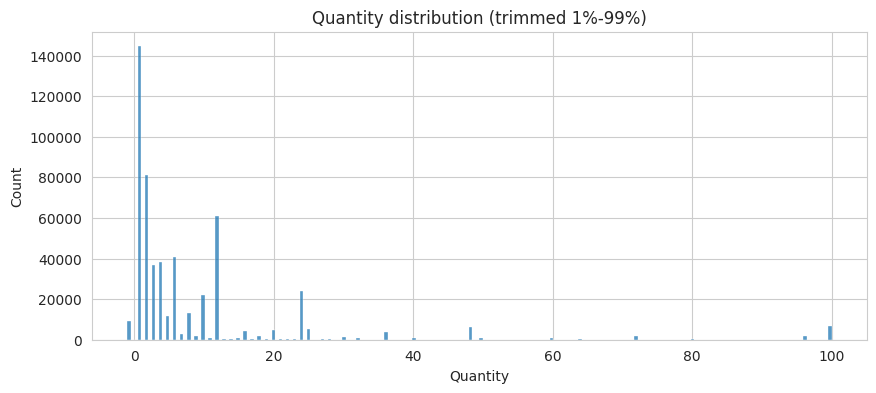

count    535294.0
mean        10.03
std        217.27
min      -80995.0
25%           1.0
50%           3.0
75%          10.0
max       80995.0
Name: Quantity, dtype: Float64


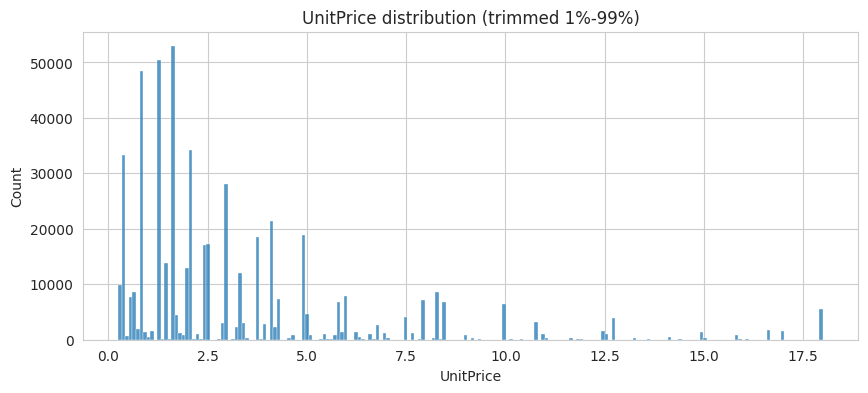

count    535294.00
mean          4.69
std          94.93
min           0.00
25%           1.25
50%           2.08
75%           4.13
max       38970.00
Name: UnitPrice, dtype: float64


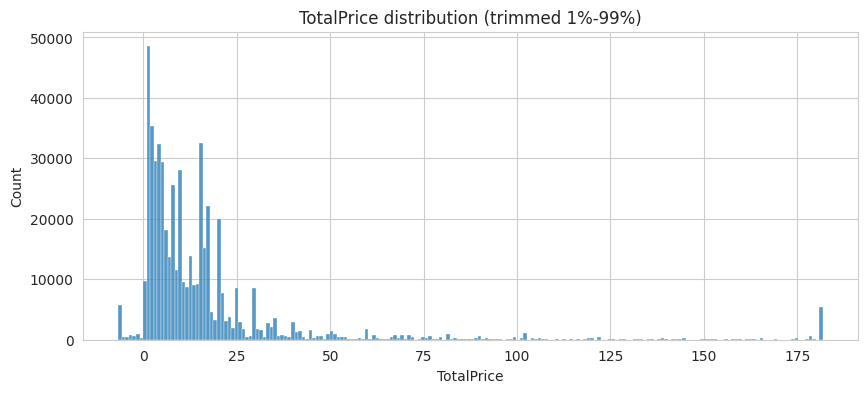

count     535294.0
mean         18.21
std         380.53
min     -168469.59
25%           3.75
50%            9.9
75%           17.4
max      168469.59
Name: TotalPrice, dtype: Float64


In [40]:
# Plot helper for numeric distributions
def plot_dist(series, title=None, bins=100, clip_percentile=(0.01,0.99)):
    s = series.dropna()
    lo, hi = s.quantile(clip_percentile[0]), s.quantile(clip_percentile[1])
    plt.figure(figsize=(10,4))
    sns.histplot(s.clip(lower=lo, upper=hi), bins=200, kde=False)
    plt.title(title or series.name)
    plt.show()
    print(series.describe().round(2))

# Quantity
plot_dist(df_clean['Quantity'], "Quantity distribution (trimmed 1%-99%)")

# UnitPrice
plot_dist(df_clean['UnitPrice'], "UnitPrice distribution (trimmed 1%-99%)")

# TotalPrice
plot_dist(df_clean['TotalPrice'], "TotalPrice distribution (trimmed 1%-99%)")


#Categorical columns & top list
###Top products, top countries, top customers by revenue.

In [41]:
# Top 15 products by revenue
top_products = (df_clean.groupby('Description')['TotalPrice']
                .sum().sort_values(ascending=False).head(15))
print("Top 15 products by revenue")
display(top_products)

# Top countries by revenue
top_countries = df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
display(top_countries.head(15))

# Top 10 customers by total spend (non-null CustomerID)
top_customers = (df_clean.dropna(subset=['CustomerID'])
                 .groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10))
print("Top 10 customers by spend")
display(top_customers)


Top 15 products by revenue


,TotalPrice
Description,
DOTCOM POSTAGE,206245.480286
REGENCY CAKESTAND 3 TIER,164459.487793
WHITE HANGING HEART T-LIGHT HOLDER,99597.119963
PARTY BUNTING,98243.879319
JUMBO BAG RED RETROSPOT,92175.788571
RABBIT NIGHT LIGHT,66661.628772
POSTAGE,66230.639969
PAPER CHAIN KIT 50'S CHRISTMAS,63715.239599
ASSORTED COLOUR BIRD ORNAMENT,58792.421878


/tmp/ipython-input-4261303666.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_countries = df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)


,TotalPrice
Country,
United Kingdom,8189093.231475
Netherlands,284661.539453
EIRE,262993.378727
Germany,221509.46892
France,197213.908979
Australia,137009.77006
Switzerland,56363.04986
Spain,54756.030083
Belgium,40910.959943


Top 10 customers by spend


,TotalPrice
CustomerID,
14646,279489.019443
18102,256438.488361
17450,187322.170972
14911,132458.729279
12415,123725.450123
14156,113214.589505
17511,88125.379833
16684,65892.079474
13694,62690.53972


#Bivariate — Quantity vs UnitPrice & correlations

##Check relationship between quantity and unit price (bulk buys, discounts), and correlation matrix for numeric features.

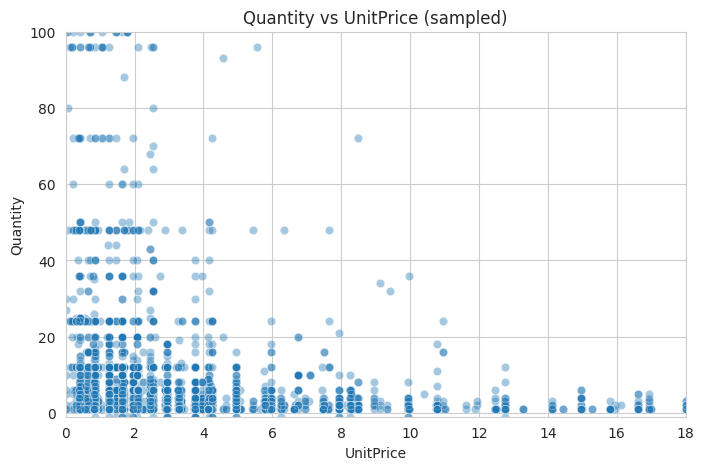

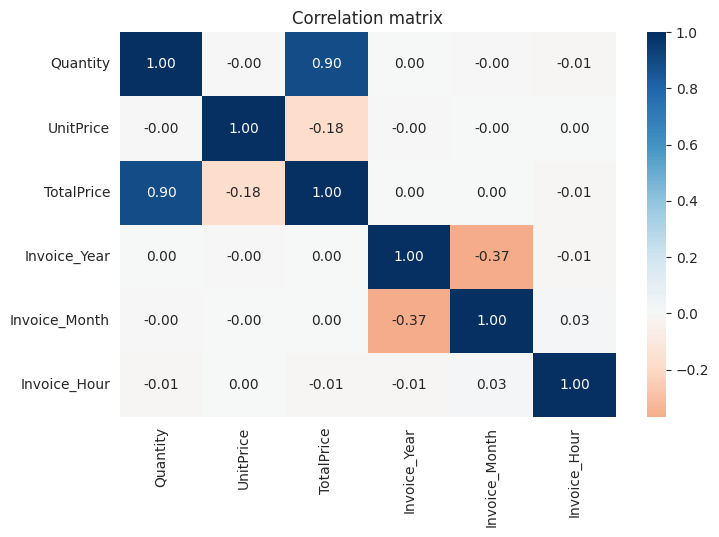

In [42]:
# Scatter Quantity vs UnitPrice: sample to avoid overplotting
samp = df_clean.sample(n=5000, random_state=42)
plt.figure(figsize=(8,5))
sns.scatterplot(x='UnitPrice', y='Quantity', data=samp, alpha=0.4)
plt.xlim(0, np.percentile(df_clean['UnitPrice'].dropna(), 99))
plt.ylim(np.percentile(df_clean['Quantity'].dropna(), 1), np.percentile(df_clean['Quantity'].dropna(), 99))
plt.title("Quantity vs UnitPrice (sampled)")
plt.show()

# Correlation matrix
num = ['Quantity','UnitPrice','TotalPrice','Invoice_Year','Invoice_Month','Invoice_Hour']
corr = df_clean[num].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu', center=0)
plt.title("Correlation matrix")
plt.show()


#Time-series / temporal analysis


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


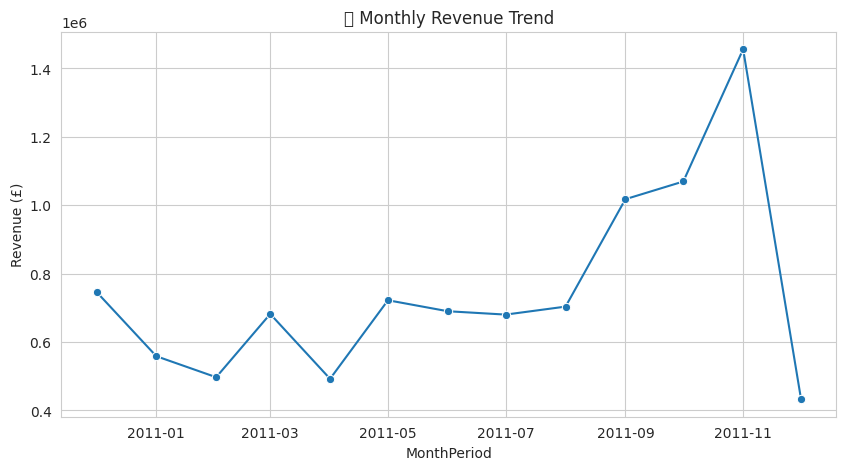

Top 5 Months by Revenue:


,Invoice_Year,Invoice_Month,total_revenue,total_invoices,total_customers
11,2011,11,1456145.792531,3325,1711
10,2011,10,1069368.223756,2491,1425
9,2011,9,1017596.676541,2229,1302
0,2010,12,746519.017542,1955,948
5,2011,5,722094.096318,2045,1079


In [47]:
# --- Monthly revenue and invoice count ---
monthly_stats = (
    df_clean
    .groupby(['Invoice_Year', 'Invoice_Month'])
    .agg(
        total_revenue=('TotalPrice', 'sum'),
        total_invoices=('InvoiceNo', 'nunique'),
        total_customers=('CustomerID', 'nunique')
    )
    .reset_index()
)

# Create datetime column for plotting
monthly_stats['MonthPeriod'] = pd.to_datetime(
    monthly_stats['Invoice_Year'].astype(str) + '-' + monthly_stats['Invoice_Month'].astype(str) + '-01'
)

# Plot
fig, ax1 = plt.subplots(figsize=(10,5))
sns.lineplot(data=monthly_stats, x='MonthPeriod', y='total_revenue', marker='o', ax=ax1)
ax1.set_ylabel('Revenue (£)')
ax1.set_title('📈 Monthly Revenue Trend')
plt.show()

# Rank months by revenue
top_months = monthly_stats.sort_values('total_revenue', ascending=False).head(5)
print("Top 5 Months by Revenue:")
display(top_months[['Invoice_Year','Invoice_Month','total_revenue','total_invoices','total_customers']])


/tmp/ipython-input-2983656069.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Invoice_DOW')
/tmp/ipython-input-2983656069.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dow_stats, x='Invoice_DOW', y='total_revenue', palette='crest')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


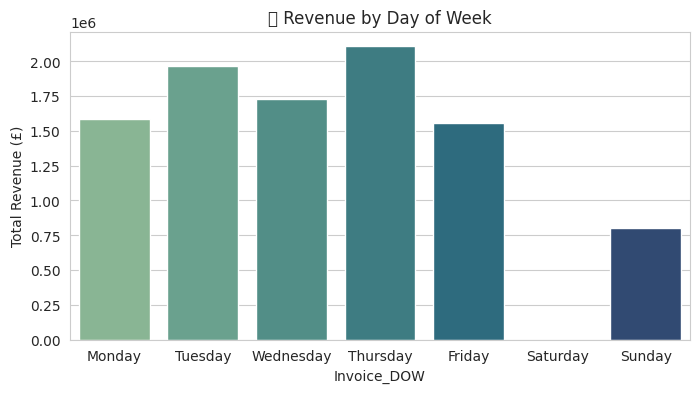

Revenue and average invoice value by weekday:


,Invoice_DOW,total_revenue,avg_invoice_value,invoices
1,Monday,1584895.29249,16.815508,3955
4,Tuesday,1965703.603077,19.49948,4466
5,Wednesday,1729883.831378,18.515491,4538
3,Thursday,2108701.519272,20.51765,5379
0,Friday,1560082.733644,19.207165,3843
2,Sunday,798659.456313,12.716292,2381


In [48]:
# --- Day of Week Aggregation ---
dow_stats = (
    df_clean
    .groupby('Invoice_DOW')
    .agg(
        total_revenue=('TotalPrice','sum'),
        avg_invoice_value=('TotalPrice','mean'),
        invoices=('InvoiceNo','nunique')
    )
    .reset_index()
    .sort_values('total_revenue', ascending=False)
)

# Keep DOW in logical order
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_stats['Invoice_DOW'] = pd.Categorical(dow_stats['Invoice_DOW'], categories=dow_order, ordered=True)
dow_stats = dow_stats.sort_values('Invoice_DOW')

# Plot
plt.figure(figsize=(8,4))
sns.barplot(data=dow_stats, x='Invoice_DOW', y='total_revenue', palette='crest')
plt.title('💸 Revenue by Day of Week')
plt.ylabel('Total Revenue (£)')
plt.show()

print("Revenue and average invoice value by weekday:")
display(dow_stats)


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


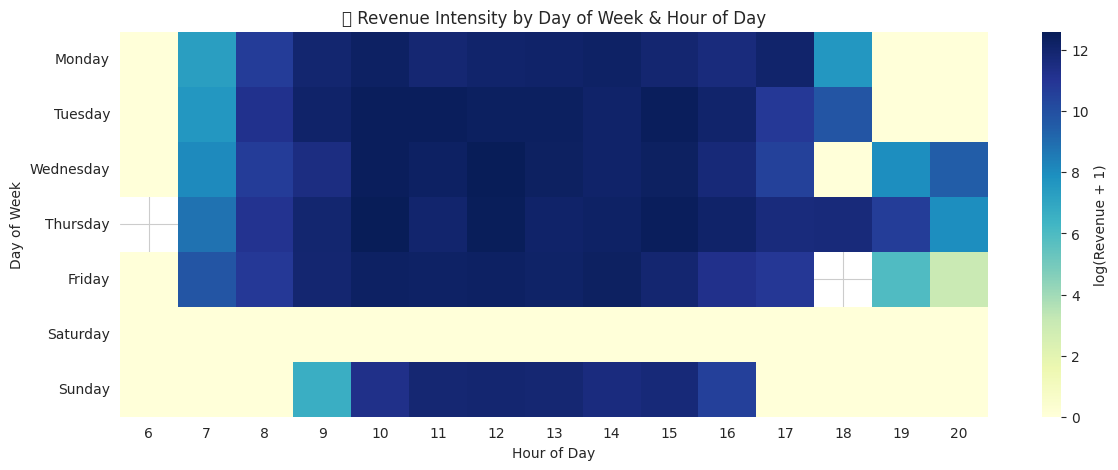

In [50]:
# --- Hourly Heatmap: which hours of the day and days of week bring in the most sales (log-scaled).
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define weekday order for readability
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Create pivot table safely
pivot = (
    df_clean.pivot_table(
        index='Invoice_DOW',
        columns='Invoice_Hour',
        values='TotalPrice',
        aggfunc='sum',
        observed=False  # explicitly set to silence the FutureWarning
    )
    .reindex(dow_order)
)

# Replace pd.NA with 0 and convert to float
pivot = pivot.fillna(0).astype(float)

# Apply log1p safely
pivot_log = np.log1p(pivot)

# Plot heatmap
plt.figure(figsize=(14,5))
sns.heatmap(pivot_log, cmap='YlGnBu', cbar_kws={'label':'log(Revenue + 1)'})
plt.title('🔥 Revenue Intensity by Day of Week & Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


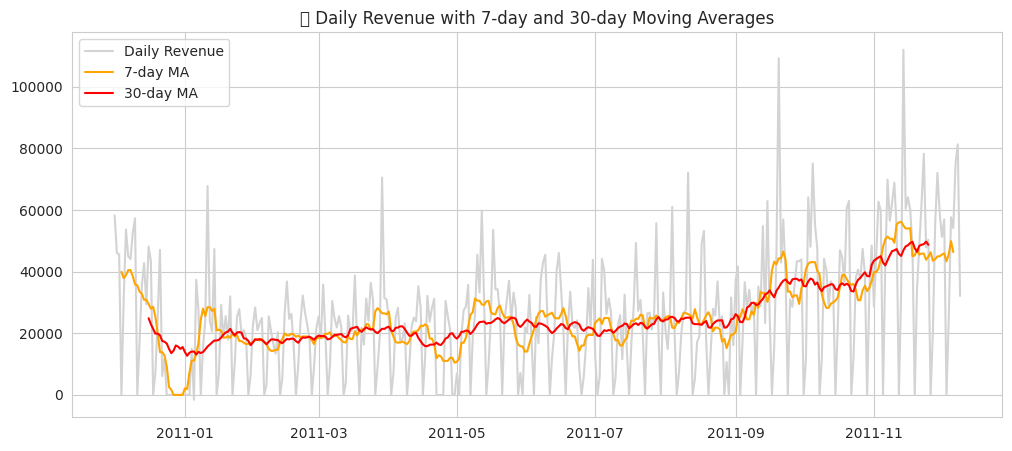

🔥 Highest 30-day revenue window: 2011-11-09 → 2011-12-08


In [51]:
#Rolling & Moving-Average Trends- To highlight sustained growth or slumps across the year
#Daily revenue time series
daily_rev = df_clean.resample('D', on='InvoiceDate_parsed')['TotalPrice'].sum().reset_index()
daily_rev['7d_MA'] = daily_rev['TotalPrice'].rolling(window=7, center=True).mean()
daily_rev['30d_MA'] = daily_rev['TotalPrice'].rolling(window=30, center=True).mean()

# Plot
plt.figure(figsize=(12,5))
plt.plot(daily_rev['InvoiceDate_parsed'], daily_rev['TotalPrice'], color='lightgray', label='Daily Revenue')
plt.plot(daily_rev['InvoiceDate_parsed'], daily_rev['7d_MA'], color='orange', label='7-day MA')
plt.plot(daily_rev['InvoiceDate_parsed'], daily_rev['30d_MA'], color='red', label='30-day MA')
plt.title('📊 Daily Revenue with 7-day and 30-day Moving Averages')
plt.legend()
plt.show()

# Identify top-performing continuous 30-day windows
rolling_sum = daily_rev['TotalPrice'].rolling(window=30).sum()
best_window_end = rolling_sum.idxmax()
best_period = daily_rev.loc[best_window_end-29:best_window_end, 'InvoiceDate_parsed']
print(f"🔥 Highest 30-day revenue window: {best_period.min().date()} → {best_period.max().date()}")


#Country comparison: UK vs Non-UK

##Compare average transaction value and average spend per customer for UK vs Non-UK.#

In [53]:
# --- Add a region flag ---
df_clean['Region'] = np.where(df_clean['Country'] == 'United Kingdom', 'UK', 'Non-UK')

# --- Overall KPIs ---
region_summary = (
    df_clean.groupby('Region')
    .agg(
        Total_Revenue=('TotalPrice','sum'),
        Num_Invoices=('InvoiceNo','nunique'),
        Num_Customers=('CustomerID','nunique'),
        Avg_Invoice_Value=('TotalPrice','mean'),
        Avg_Quantity=('Quantity','mean')
    )
    .round(2)
    .reset_index()
)

display(region_summary)


,Region,Total_Revenue,Num_Invoices,Num_Customers,Avg_Invoice_Value,Avg_Quantity
0,Non-UK,1558833.2,2407,423,33.64,19.68
1,UK,8189093.23,22156,3950,16.75,9.12


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


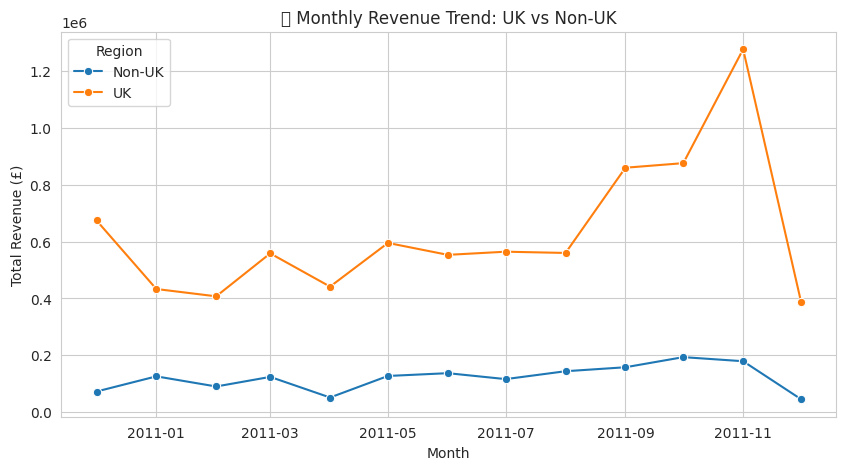

Top 3 Months by Revenue for each Region:


,Invoice_Year,Invoice_Month,Region,total_revenue,MonthPeriod
20,2011,10,Non-UK,193121.778842,2011-10-01
22,2011,11,Non-UK,178736.009196,2011-11-01
18,2011,9,Non-UK,157492.319636,2011-09-01
23,2011,11,UK,1277409.783335,2011-11-01
21,2011,10,UK,876246.444914,2011-10-01
19,2011,9,UK,860104.356905,2011-09-01


In [54]:
#Monthly Trend (UK Vs non-UK)
# --- Monthly revenue for both regions ---
monthly_region = (
    df_clean
    .groupby(['Invoice_Year','Invoice_Month','Region'])
    .agg(total_revenue=('TotalPrice','sum'))
    .reset_index()
)

monthly_region['MonthPeriod'] = pd.to_datetime(
    monthly_region['Invoice_Year'].astype(str) + '-' + monthly_region['Invoice_Month'].astype(str) + '-01'
)

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_region, x='MonthPeriod', y='total_revenue', hue='Region', marker='o')
plt.title('📈 Monthly Revenue Trend: UK vs Non-UK')
plt.ylabel('Total Revenue (£)')
plt.xlabel('Month')
plt.show()

# Identify top months for each region
top_months_by_region = (
    monthly_region
    .sort_values(['Region','total_revenue'], ascending=[True,False])
    .groupby('Region')
    .head(3)
)
print("Top 3 Months by Revenue for each Region:")
display(top_months_by_region)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


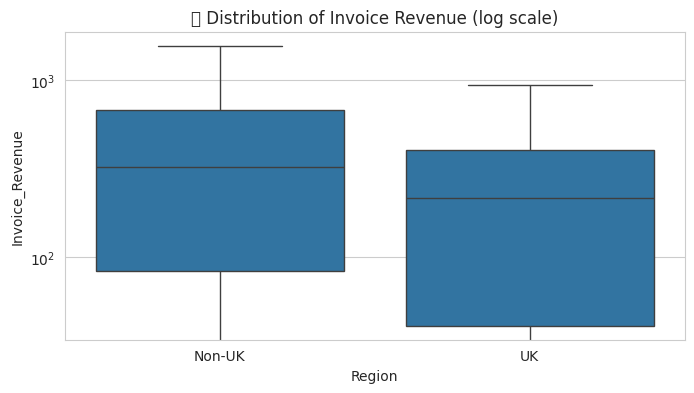

,Avg_Invoice_Revenue,Median_Invoice_Revenue,Avg_Items
Region,,,
Non-UK,647.62,324.92,378.94
UK,369.61,217.2,201.18


In [55]:
# Invoice level analysis (UK Vs non-UK)
invoice_behavior = (
    df_clean.groupby(['InvoiceNo','Region'])
    .agg(
        Invoice_Revenue=('TotalPrice','sum'),
        Num_Items=('Quantity','sum'),
        Avg_UnitPrice=('UnitPrice','mean')
    )
    .reset_index()
)

plt.figure(figsize=(8,4))
sns.boxplot(data=invoice_behavior, x='Region', y='Invoice_Revenue', showfliers=False)
plt.yscale('log')
plt.title('💰 Distribution of Invoice Revenue (log scale)')
plt.show()

invoice_summary = invoice_behavior.groupby('Region').agg(
    Avg_Invoice_Revenue=('Invoice_Revenue','mean'),
    Median_Invoice_Revenue=('Invoice_Revenue','median'),
    Avg_Items=('Num_Items','mean')
).round(2)
display(invoice_summary)


#RFM
###Running the analysis on a subset, after trying imputation

In [56]:
# A: Invoice-based imputation on a copy (do not overwrite df_clean)
df_impute = df_clean.copy()
df_impute['CustomerID'] = df_impute.groupby('InvoiceNo')['CustomerID'].transform(
    lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# B: df_customer to use for customer-level analyses (drop remaining NaNs)
df_customer = df_impute.dropna(subset=['CustomerID']).copy()
df_customer['CustomerID'] = df_customer['CustomerID'].astype('Int64')

print("Original rows:", df_clean.shape[0])
print("After invoice-impute (rows):", df_impute.shape[0])
print("Rows with CustomerID after impute (df_customer):", df_customer.shape[0])
print("Unique customers in df_customer:", df_customer['CustomerID'].nunique())


/tmp/ipython-input-884555348.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill'))


Original rows: 535294
After invoice-impute (rows): 535294
Rows with CustomerID after impute (df_customer): 401595
Unique customers in df_customer: 4372


In [57]:
# Snapshot date = day after last transaction
snapshot = df_customer['InvoiceDate_parsed'].max() + pd.Timedelta(days=1)

rfm = (df_customer.groupby('CustomerID')
       .agg(Recency = ('InvoiceDate_parsed', lambda x: (snapshot - x.max()).days),
            Frequency = ('InvoiceNo','nunique'),
            Monetary = ('TotalPrice','sum'))
       .reset_index())

# Keep only positive monetary customers
rfm = rfm[rfm['Monetary']>0].copy()
rfm.describe().round(2)


,CustomerID,Recency,Frequency,Monetary
count,4318.0,4318.00,4318.00,4318.0
mean,15300.45,90.36,5.12,1920.23
std,1720.18,99.15,9.39,8266.08
min,12347.0,1.00,1.00,0.0
25%,13815.25,17.00,1.00,300.95
50%,15299.5,49.00,3.00,653.56
75%,16777.75,138.00,6.00,1624.19
max,18287.0,374.00,248.00,279489.02


In [58]:
# Score into quintiles
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Simple mapping to high-level segment (example)
def rfm_segment(row):
    if row['RFM_score'] == '555':
        return 'Champions'
    if row['R_score'] >=4 and row['M_score'] >=4:
        return 'Loyal/High Value'
    if row['R_score'] <=2 and row['F_score'] <=2:
        return 'At Risk'
    return 'Others'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)
rfm['Segment'].value_counts()


,count
Segment,
Others,2222
At Risk,1041
Loyal/High Value,715
Champions,340


In [59]:
# Profile segments
seg_profile = rfm.groupby('Segment').agg(
    customers=('CustomerID','nunique'),
    Recency_median=('Recency','median'),
    Frequency_median=('Frequency','median'),
    Monetary_median=('Monetary','median')
).sort_values('Monetary_median', ascending=False).reset_index()
display(seg_profile)


,Segment,customers,Recency_median,Frequency_median,Monetary_median
0,Champions,340,4.0,16.0,4593.264977
1,Loyal/High Value,715,16.0,6.0,1769.779946
2,Others,2222,50.0,3.0,584.064996
3,At Risk,1041,215.0,1.0,280.55


,Total_Revenue,Customers,Revenue_Share,Customer_Share
Segment,,,,
Champions,3788485.12,340,45.69,7.87
Others,2116462.55,2222,25.53,51.46
Loyal/High Value,1970830.85,715,23.77,16.56
At Risk,415765.41,1041,5.01,24.11


/tmp/ipython-input-3603560793.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seg_contrib.reset_index(), x='Segment', y='Revenue_Share', palette='crest')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


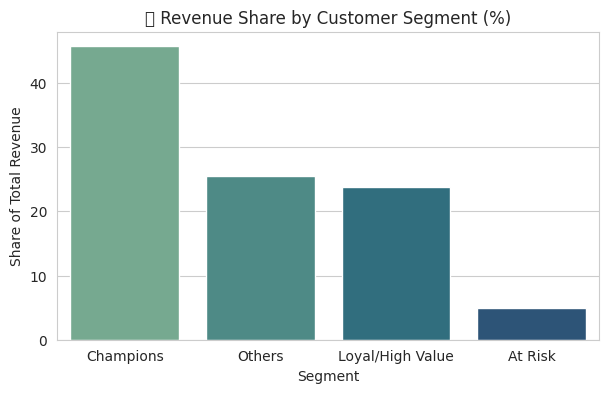

In [61]:
#Segment Contribution Analysis (Revenue, Customers, Share)

#Purpose: quantify how much each segment contributes to total revenue and total customers.#


seg_contrib = (
    rfm.groupby('Segment')
    .agg(
        Total_Revenue=('Monetary','sum'),
        Customers=('CustomerID','nunique')
    )
    .assign(
        Revenue_Share=lambda x: 100 * x['Total_Revenue'] / x['Total_Revenue'].sum(),
        Customer_Share=lambda x: 100 * x['Customers'] / x['Customers'].sum()
    )
    .sort_values('Total_Revenue', ascending=False)
    .round(2)
)

display(seg_contrib)

# Visualize
plt.figure(figsize=(7,4))
sns.barplot(data=seg_contrib.reset_index(), x='Segment', y='Revenue_Share', palette='crest')
plt.title("💰 Revenue Share by Customer Segment (%)")
plt.ylabel("Share of Total Revenue")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


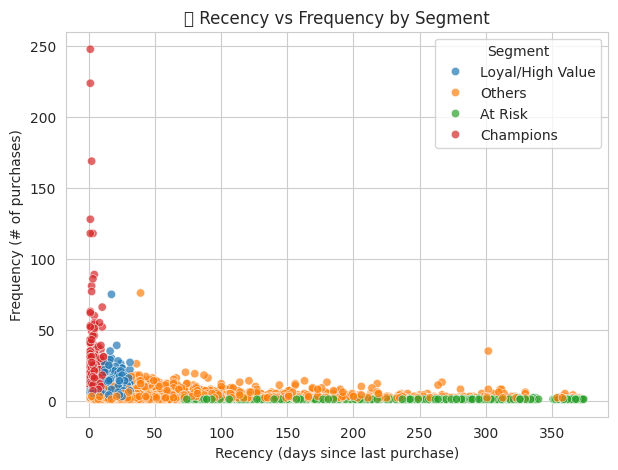

In [62]:
#Recency-Frequency Relationship

#Purpose: visualize behavior patterns are frequent buyers also recent, or is there decay?

plt.figure(figsize=(7,5))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', alpha=0.7)
plt.title('🕒 Recency vs Frequency by Segment')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (# of purchases)')
plt.show()


/tmp/ipython-input-2489204369.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm.groupby('Recency_Bin')['Monetary']
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


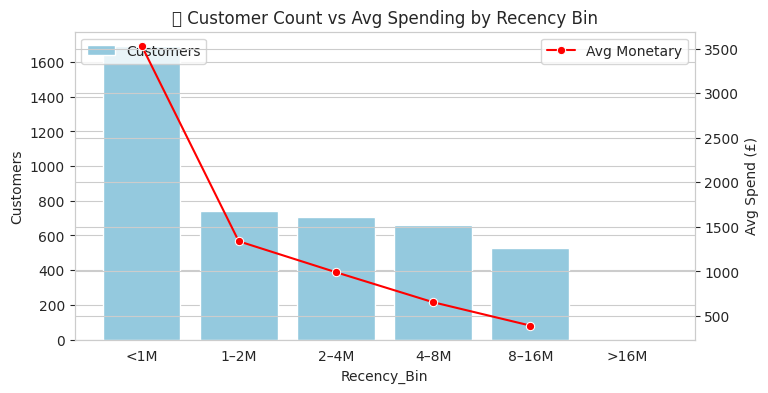

In [63]:
#Purchase Lifecycle Visualization

#Purpose: show how customer activity changes across recency buckets.

rfm['Recency_Bin'] = pd.cut(rfm['Recency'], bins=[0,30,60,120,240,480,10000],
                            labels=['<1M','1–2M','2–4M','4–8M','8–16M','>16M'])

recency_trend = (
    rfm.groupby('Recency_Bin')['Monetary']
    .agg(['count','mean'])
    .rename(columns={'count':'Customers','mean':'Avg_Monetary'})
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(8,4))
sns.barplot(data=recency_trend, x='Recency_Bin', y='Customers', ax=ax1, color='skyblue', label='Customers')
ax2 = ax1.twinx()
sns.lineplot(data=recency_trend, x='Recency_Bin', y='Avg_Monetary', marker='o', color='red', ax=ax2, label='Avg Monetary')
ax1.set_title("📅 Customer Count vs Avg Spending by Recency Bin")
ax1.set_ylabel("Customers")
ax2.set_ylabel("Avg Spend (£)")
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.show()


In [64]:
#Segment–Product Relationship (Top Products by Segment)

#Purpose: find which products each segment buys most, useful for targeted marketing

# Merge segment info back into df_clean
df_seg = df_clean.merge(rfm[['CustomerID','Segment']], on='CustomerID', how='left')

# Example: top 5 products by segment (revenue-based)
top_products_seg = (
    df_seg.groupby(['Segment','Description'])
    ['TotalPrice'].sum()
    .reset_index()
    .sort_values(['Segment','TotalPrice'], ascending=[True,False])
    .groupby('Segment')
    .head(5)
)

display(top_products_seg)


,Segment,Description,TotalPrice
2062,At Risk,REGENCY CAKESTAND 3 TIER,5758.34996
1940,At Risk,POSTAGE,5400.6
2747,At Risk,WHITE HANGING HEART T-LIGHT HOLDER,4565.600008
1754,At Risk,PARTY BUNTING,3753.699934
2458,At Risk,SMALL POPCORN HOLDER,3315.300129
5377,Champions,REGENCY CAKESTAND 3 TIER,76370.998922
6249,Champions,WHITE HANGING HEART T-LIGHT HOLDER,48976.049714
4473,Champions,JUMBO BAG RED RETROSPOT,44254.759139
3223,Champions,BLACK RECORD COVER FRAME,29549.210865
5010,Champions,PARTY BUNTING,28639.22985


/tmp/ipython-input-2524664120.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_seg.groupby(['Segment','Country'])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127758 (\N{EARTH GLOBE AMERICAS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


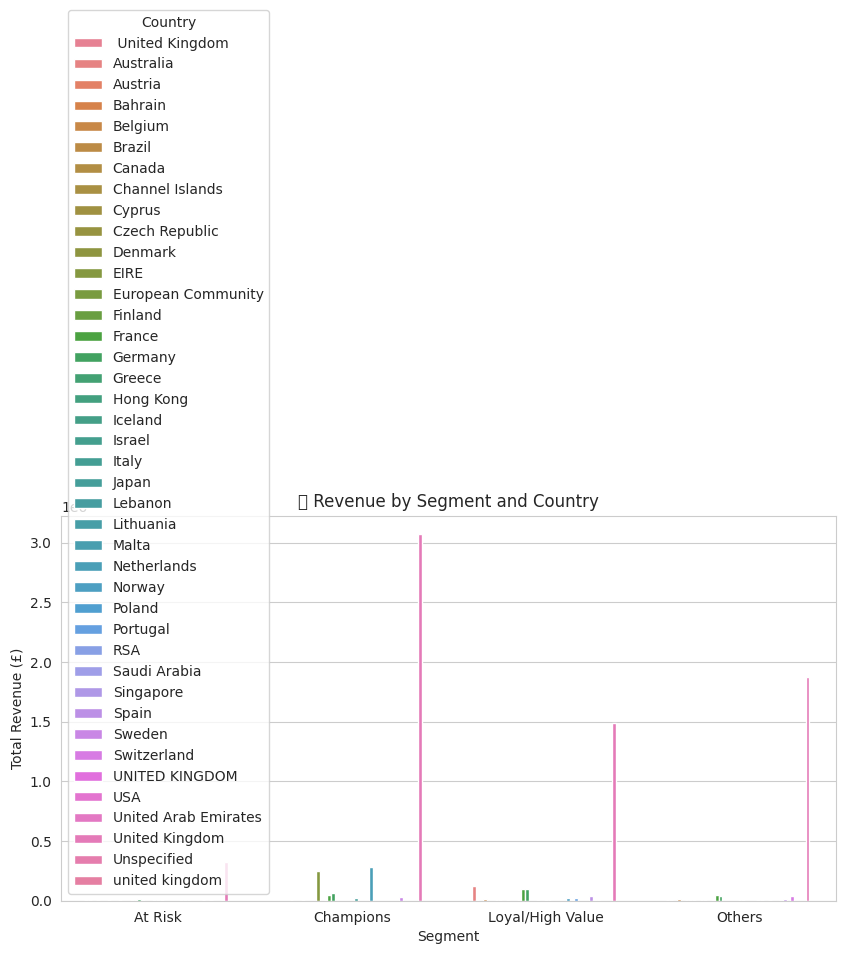

In [65]:
#Segment–Country Mix (UK vs Non-UK)

#Purpose: see whether high value customers are concentrated in specific regions

df_seg_region = (
    df_seg.groupby(['Segment','Country'])
    ['TotalPrice'].sum()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.barplot(data=df_seg_region, x='Segment', y='TotalPrice', hue='Country')
plt.title("🌎 Revenue by Segment and Country")
plt.ylabel("Total Revenue (£)")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


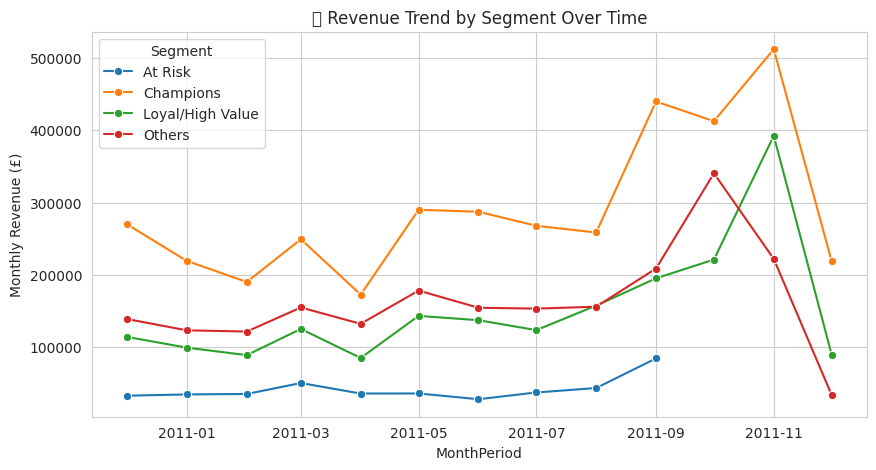

In [66]:
#Segment Trend Over Time

#Purpose: detect whether segments are growing or shrinking month-by-month

# Add RFM segments into monthly-level aggregation
df_seg['MonthPeriod'] = df_seg['InvoiceDate_parsed'].dt.to_period('M').dt.to_timestamp()

segment_trend = (
    df_seg.groupby(['MonthPeriod','Segment'])['TotalPrice'].sum().reset_index()
)

plt.figure(figsize=(10,5))
sns.lineplot(data=segment_trend, x='MonthPeriod', y='TotalPrice', hue='Segment', marker='o')
plt.title("📆 Revenue Trend by Segment Over Time")
plt.ylabel("Monthly Revenue (£)")
plt.show()


#Clustering (KMeans) on log-transformed RFM

To discover natural clusters beyond rule-based RFM. We'll show elbow and then kmeans=4 (say)

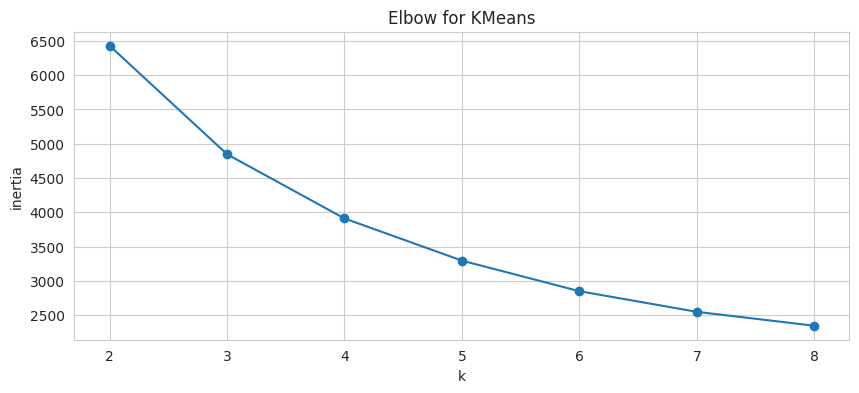

,Recency,Frequency,Monetary,size
Cluster,,,,
1,8.0,12.0,3579.46,720
2,51.0,5.0,1325.55,1138
3,17.0,2.0,454.33,855
0,174.0,1.0,290.82,1605


In [67]:
# Prepare features
X = np.log1p(rfm[['Recency','Frequency','Monetary']])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method
inertia = []
K = range(2,9)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, '-o'); plt.xlabel('k'); plt.ylabel('inertia'); plt.title('Elbow for KMeans'); plt.show()

# Choose k (example 4)
k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=10)
rfm['Cluster'] = km.fit_predict(X_scaled)

# Cluster profiles
cluster_profile = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].median().round(2)
cluster_profile['size'] = rfm.groupby('Cluster').size()
display(cluster_profile.sort_values('Monetary', ascending=False))


#Cluster 1 — “Champions / Premium Loyalists”

Recency: 8 days → very recent buyers

Frequency: 12 → buy very frequently

Monetary: ~₹3,579 (highest)

Size: 720 customers (≈ top 15-20%)

💬 Inference:
These are your top-tier, high-value customers.
They buy often, recently, and spend the most.

→ Maintain strong relationships, offer loyalty rewards, early product access, or personalized deals.


#Cluster 2 — “Loyal / Regular Customers”

Recency: 51 days → somewhat recent

Frequency: 5 → moderate repeat buyers

Monetary: ~₹1,325

Size: 1138 customers

💬 Inference:
These customers are steady repeat purchasers — not as elite as Cluster 1 but reliable.
They might buy monthly or quarterly.
→ Encourage them toward premium products, cross-sell, or membership programs.

# Cluster 3 — “New or Low-Spend Recent Customers”

Recency: 17 days → recent buyers

Frequency: 2 → low repeat

Monetary: ~₹454

Size: 855 customers

💬 Inference:
These are new or infrequent but recent customers.
→ Nurture and onboard them — send follow-up offers, product recommendations, and reminders to re-purchase.

#Cluster 0 — “At-Risk / Dormant Customers”

Recency: 174 days → haven’t purchased in months

Frequency: 1 → single purchase (one-time buyers)

Monetary: ~₹290 (lowest)

Size: 1605 customers (largest segment!)

💬 Inference:
These customers are churned or nearly churned.
They bought once a long time ago and never returned.
→ Reactivation campaigns: discounts, “we miss you” emails, seasonal promos.


#Business-level summary (great for your report)
| Key Finding                               | Business Meaning                       | Actionable Strategy                           |
| ----------------------------------------- | -------------------------------------- | --------------------------------------------- |
| Cluster 1 has highest spend & frequency   | Loyal customers with strong engagement | Retain with VIP perks, personalized campaigns |
| Cluster 2 moderately active               | Stable customer base                   | Upsell premium items, loyalty programs        |
| Cluster 3 recently acquired but low spend | Onboarding needed                      | Welcome discounts, nurture emails             |
| Cluster 0 large & inactive                | Customer churn                         | Win-back offers, reactivation campaign        |


#Market-basket analysis (Apriori) — UK & top-N items

##Run Apriori on UK invoices restricted to top N descriptions to keep matrix manageable.

In [68]:
# Filter UK and top N products
uk = df_clean[df_clean['Country']=='United Kingdom'].copy()
topN = 200
top_products = uk['Description'].value_counts().head(topN).index
uk_top = uk[uk['Description'].isin(top_products)]

# Build invoice-level lists
transactions = uk_top.groupby('InvoiceNo')['Description'].apply(list).tolist()

# TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

# Apriori and rules
frequent_items = apriori(basket_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_items, metric='lift', min_threshold=1.2)
rules_sorted = rules.sort_values(['lift','confidence'], ascending=False)
display(rules_sorted.head(10))


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4346,"(CHARLOTTE BAG SUKI DESIGN, CHARLOTTE BAG PINK...","(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...",0.014792,0.024390,0.011179,0.755725,30.984733,1.0,0.010818,3.993902,0.982256,0.399194,0.749618,0.607029
4359,"(RED RETROSPOT CHARLOTTE BAG, WOODLAND CHARLOT...","(CHARLOTTE BAG SUKI DESIGN, CHARLOTTE BAG PINK...",0.024390,0.014792,0.011179,0.458333,30.984733,1.0,0.010818,1.818845,0.991919,0.399194,0.450201,0.607029
4351,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...","(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...",0.017841,0.020607,0.011179,0.626582,30.405549,1.0,0.010811,2.622780,0.984679,0.409938,0.618725,0.584524
4354,"(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...","(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...",0.020607,0.017841,0.011179,0.542466,30.405549,1.0,0.010811,2.146635,0.987460,0.409938,0.534155,0.584524
4349,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...","(CHARLOTTE BAG PINK POLKADOT, WOODLAND CHARLOT...",0.018293,0.020269,0.011179,0.611111,30.150418,1.0,0.010808,2.519309,0.984848,0.408247,0.603066,0.581322
4356,"(CHARLOTTE BAG PINK POLKADOT, WOODLAND CHARLOT...","(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...",0.020269,0.018293,0.011179,0.551532,30.150418,1.0,0.010808,2.189024,0.986835,0.408247,0.543175,0.581322
4344,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...","(STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ...",0.017841,0.021229,0.011179,0.626582,29.516025,1.0,0.010800,2.621117,0.983670,0.400810,0.618483,0.576589
4361,"(STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ...","(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG SU...",0.021229,0.017841,0.011179,0.526596,29.516025,1.0,0.010800,2.074673,0.987074,0.400810,0.517996,0.576589
4345,"(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG PI...","(CHARLOTTE BAG SUKI DESIGN, STRAWBERRY CHARLOT...",0.016994,0.022301,0.011179,0.657807,29.496413,1.0,0.010800,2.857158,0.982799,0.397590,0.650002,0.579537
4360,"(CHARLOTTE BAG SUKI DESIGN, STRAWBERRY CHARLOT...","(RED RETROSPOT CHARLOTTE BAG, CHARLOTTE BAG PI...",0.022301,0.016994,0.011179,0.501266,29.496413,1.0,0.010800,1.971002,0.988134,0.397590,0.492644,0.579537


#Forecasting monthly revenue (Prophet)

##Forecast monthly revenue using df_clean aggregated to month.

/tmp/ipython-input-3779885905.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_clean.set_index('InvoiceDate_parsed').resample('M')['TotalPrice'].sum().reset_index()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzef9xmw/swatdk2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzef9xmw/3e_om2fb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55764', 'data', 'file=/tmp/tmpjzef9xmw/swatdk2t.json', 'init=/tmp/tmpjzef9xmw/3e_om2fb.json', 'output', 'file=/tmp/tmpjzef9xmw/prophet_modelr0dhzuar/prophet_model

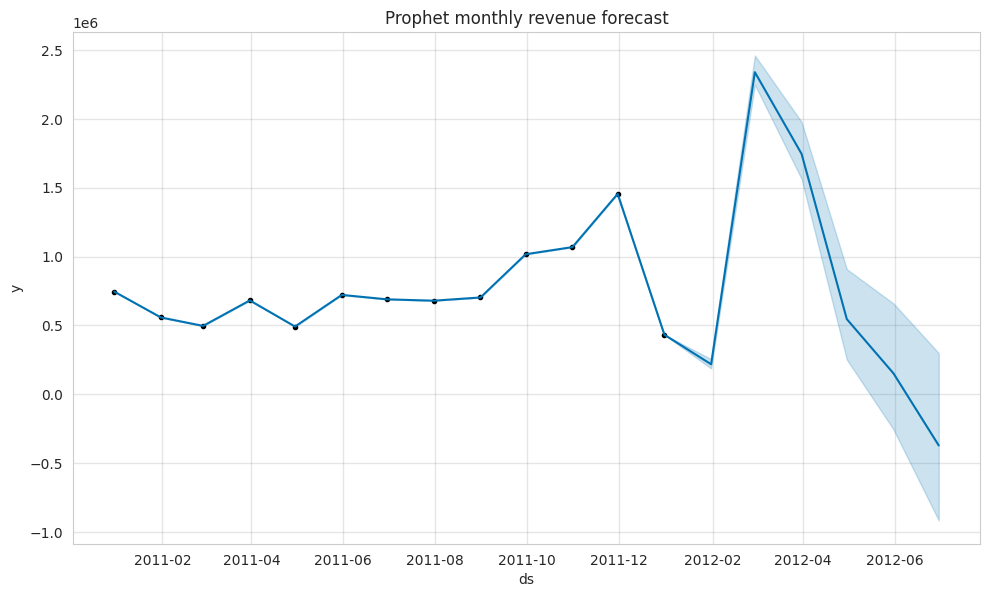

In [69]:
monthly = df_clean.set_index('InvoiceDate_parsed').resample('M')['TotalPrice'].sum().reset_index()
monthly = monthly.rename(columns={'InvoiceDate_parsed':'ds','TotalPrice':'y'})

if PROPHET_AVAILABLE:
    m = Prophet(yearly_seasonality=True)
    m.fit(monthly)
    future = m.make_future_dataframe(periods=6, freq='M')
    forecast = m.predict(future)
    fig = m.plot(forecast); plt.title('Prophet monthly revenue forecast'); plt.show()
else:
    print("Prophet not available. To install: pip install prophet (or 'prophet' package).")
    display(monthly.tail())


#Hypothesis testing & CI (as per case doc)

##Compute 95% bootstrap CI for average spend, one-sample t-test vs $1200, ANOVA for segments, chi-square relationship tests.

In [70]:
# Use 'rfm' monetary values
vals = rfm['Monetary'].values

# 95% bootstrap CI
np.random.seed(42)
n_boot = 2000
means = [np.mean(np.random.choice(vals, size=len(vals), replace=True)) for _ in range(n_boot)]
ci_lower, ci_upper = np.percentile(means, [2.5,97.5])
print(f"95% bootstrap CI for mean monetary: [{ci_lower:.2f}, {ci_upper:.2f}]")

# One-sample t-test vs 1200
t_stat, p_val = stats.ttest_1samp(vals, 1200)
print("t-stat:", t_stat, "p-value:", p_val)

# ANOVA across 'Segment' (coarse segments from rfm)
groups = [g['Monetary'].values for n,g in rfm.groupby('Segment')]
fstat, p_anova = f_oneway(*groups)
print("ANOVA F:", fstat, "p:", p_anova)

# Chi-square: is UK vs Non-UK associated with Monetarily segment (requires customer-country mapping)
cust_country = (df_clean.dropna(subset=['CustomerID'])
                .drop_duplicates(subset=['CustomerID'])[['CustomerID','Country']])
rfm_small = rfm.merge(cust_country, on='CustomerID', how='left')
rfm_small['is_UK'] = rfm_small['Country']=='United Kingdom'
ct = pd.crosstab(rfm_small['is_UK'], rfm_small['Segment'])
chi2, p_chi, dof, exp = chi2_contingency(ct.fillna(0))
print("Chi2:", chi2, "p:", p_chi)


95% bootstrap CI for mean monetary: [1702.17, 2194.35]
t-stat: 5.725473899363177 p-value: 1.1014447699617345e-08
ANOVA F: 186.76221208245676 p: 7.290799641538075e-114
Chi2: 29.987972648257795 p: 1.3881198409481213e-06


#Predictive modelling — classify HighValue customers

##Build a RandomForest to predict whether a customer is in the top 20% Monetary (HighValue). Use Recency/Frequency/Monetary as baseline features.

In [71]:
# Define target
rfm['HighValue'] = (rfm['Monetary'] >= rfm['Monetary'].quantile(0.8)).astype(int)
X = rfm[['Recency','Frequency','Monetary']]
y = rfm['HighValue']

# Train-test and model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))

# Feature importance
fi = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(fi)


Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       691
           1       1.00      1.00      1.00       173

    accuracy                           1.00       864
   macro avg       1.00      1.00      1.00       864
weighted avg       1.00      1.00      1.00       864

ROC AUC: 1.0


,0
Monetary,0.714812
Frequency,0.230553
Recency,0.054635


#Anomaly detection on invoices

##Use IsolationForest on invoice totals to find outliers (e.g., data errors or fraud).

In [72]:
invoice_totals = df_clean.groupby('InvoiceNo').agg(InvoiceTotal=('TotalPrice','sum')).reset_index()
iso = IsolationForest(contamination=0.01, random_state=42)
invoice_totals['anomaly'] = iso.fit_predict(invoice_totals[['InvoiceTotal']])
anomalies = invoice_totals[invoice_totals['anomaly']==-1].sort_values('InvoiceTotal', ascending=False).head(30)
display(anomalies)


,InvoiceNo,InvoiceTotal,anomaly
20689,581483,168469.593821,-1
2202,541431,77183.597169,-1
17582,574941,52940.939363,-1
18251,576365,50653.909415,-1
9034,556444,38970.0,-1
14071,567423,31698.160014,-1
9240,556917,22775.929987,-1
16293,572209,22205.999565,-1
14063,567381,22104.799839,-1
12335,563614,21880.440172,-1


#Quick item-to-item recommender (co-occurrence)

## Fast co-occurrence recommender for demo (use top 200 items).

In [73]:
top_items = df_clean['Description'].value_counts().head(200).index
df_top = df_clean[df_clean['Description'].isin(top_items)]
co = pd.crosstab(df_top['InvoiceNo'], df_top['Description']).astype(int)
co_occ = co.T.dot(co)

def recommend_item(item_name, n=10):
    if item_name not in co_occ.index:
        return f"No data for {item_name}"
    scores = co_occ[item_name].sort_values(ascending=False)
    return scores.head(n+1).iloc[1:]

# Example
example_item = top_items[0]
print("Recommendations for:", example_item)
display(recommend_item(example_item, n=10))


Recommendations for: WHITE HANGING HEART T-LIGHT HOLDER


,WHITE HANGING HEART T-LIGHT HOLDER
Description,
RED HANGING HEART T-LIGHT HOLDER,520
JUMBO BAG RED RETROSPOT,473
NATURAL SLATE HEART CHALKBOARD,433
WOODEN PICTURE FRAME WHITE FINISH,423
HEART OF WICKER SMALL,414
PARTY BUNTING,406
REGENCY CAKESTAND 3 TIER,377
HEART OF WICKER LARGE,375
LUNCH BAG RED RETROSPOT,352
